In [1]:
#constellate: setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import colorcet as cc
import scipy
from sympy import *
import rho_plus

IS_DARK = True
theme, cs = rho_plus.mpl_setup(IS_DARK)

import panel as pn
import param
import bokeh
pn.extension('gridstack', sizing_mode='scale_both')
from panel.layout.gridstack import GridStack

# Metropolis-Hastings In the Real World

Last time, I introduced the Metropolis-Hastings algorithm for approximating probability distributions with an unknown normalizing factor, and I alluded to applications of this algorithm in Bayesian inference. I also mentioned how I chose a particularly easy example and that the real world poses more serious challenges.

Today, the training wheels are coming off! I'll be applying Metropolis-Hastings to do Bayesian inference in a problem like the ones you might encounter in the real world doing machine learning. We won't know the true distribution we're approximating, and we'll have to deal with the kinds of restrictions that come up in practice.

When we're trying to fit a probabilistic model to the real world, we aren't usually interested in the minutia of the code, and we want the feedback loop between proposing a model and getting results to be as quick and painless as possible. As such, I'll pay extra attention to how Metropolis-Hastings can be automated into an "inference button" that, given a set of prior beliefs and evidence, gives us our new beliefs with as little hand tuning as possible. Let's get started!

## Problem Setup

### Gaussian Mixture Models

We'll be fitting something known as a *Gaussian mixture model.* Specifically, a Gaussian mixture model is a generalization of the normal (or Gaussian, hence the name) distribution. Instead of having a single normal distribution, we imagine a dataset created by mixing multiple Gaussian distributions with different frequencies.

This is important because, in the real world, there are often important *latent variables*—unseen information that affects the data you have—that we don't know about. Many real-world datasets are roughly normally distributed, or at least unimodal: having a single peak. So, if a dataset looks strongly multimodal, having several distinct peaks, that's a hint that there's more to the story. We should probably be hunting for hidden variables that explain our data better than our current models, and we should be suspicious of many machine learning techniques that assume normally distributed or unimodal data. Examples from the real world:

 * If response to a medical treatment is bimodal, perhaps the treatment works differently in people with a specific gene.
 * If customer behavior is multimodal, that might indicate different segments of a market that could be identified.
 * If political preferences are multimodal, then perhaps those modes represent different voting blocs that should be accounted for when polling.

Text(0.5, 1.0, 'Mixture of Two Normal Distributions')

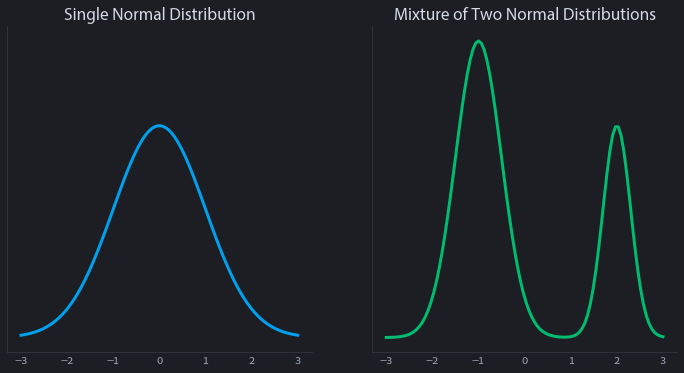

In [2]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

xx = np.linspace(-3, 3, 100)

ax1.plot(xx, stats.norm.pdf(xx), color=cs[0], lw=3)
ax2.plot(xx, 0.7 * stats.norm(loc=-1, scale=0.5).pdf(xx) + 0.3 * stats.norm(loc=2, scale=0.3).pdf(xx), color=cs[1], lw=3)

ax1.set_yticks([])

ax1.set_title('Single Normal Distribution')
ax2.set_title('Mixture of Two Normal Distributions')

There's a chicken-and-egg problem that rears its ugly head here. It's quite simple to fit an normal distribution to a dataset: just take the mean and standard deviation of the data, and the normal distribution with that mean and standard deviation will be the best fit. But if our dataset is clustered into different parts, we can't easily estimate the parameters of the different mixture model components without knowing which parts of the data fall into each category. But we can't estimate which data points fall into which category until we know what the categories look like!

This is a problem with a long history, and there are many approaches. Bayesian statistics provides an especially elegant approach that we'll be using, but I'd be remiss not to point out how this problem appears in a guise you may not recognize at first.

### K-Means Clustering as Gaussian Mixture Modeling

Let's say we have some data we want to split into clusters. A common algorithm for doing this defines a cluster using a cluster center. Each point then gets assigned to the cluster center that it's closest to. We can fit this model using a technique called *Lloyd's algorithm*:

 * Start with $k$ cluster centers, initialized however we like.[^1]
 * Repeat the following two steps until the cluster centers no longer change:
   * Assign each point to the cluster of the center it's closest to.
   * Move each cluster center to the centroid (average) of all of the points of its cluster.

[^1]: How you do this matters a fair bit—this is one of the weaknesses of k-means. We're not going to worry about it here, but if you're using this in the real world you should look at k-means++ and similar initialization strategies.

In [3]:
#constellate: setup_panel

from bokeh.sampledata.iris import flowers
from rho_plus.util import labelcase
import holoviews as hv
from holoviews import opts

flowers.columns = labelcase(flowers.columns)

You can see how this works for a random dataset opposite. We start with a bad setup and converge to a good one over time. Things won't work the same each time, and there are cases in which this sequence of steps does not converge well at all.

In [12]:
from scipy.spatial import Voronoi

# generate dataset with clusters
np.random.seed(3143)
nd = np.array([50, 30, 20, 10])
xlim = np.array([-5, 5])
ylim = np.array([-5, 5])

mu = np.array([[3, -3], [-3, 3], [3, 3], [-3, -3]])
sigma = np.array([1, 2, 1, 1])

pts = []
for mean, sd, n in zip(mu, sigma, nd):
    pts += list(stats.multivariate_normal(mean, sd).rvs(n))

pts = np.array(pts)

rng: np.random.BitGenerator = np.random.default_rng(310)

class KMeans(rho_plus.ThemedPanel):
    centers = param.Array(default=None, precedence=-1)
    assignments = param.Array(default=None, precedence=-1)
    phase = param.ObjectSelector(['expectation', 'maximization'], precedence=-1)
    
    def __init__(self):
        super().__init__()
        self.initialize_centers()

    def initialize_centers(self):
        self.centers = rng.multivariate_normal(np.array([2, 2]), np.eye(2) * 0.5, len(nd))
        self.phase = 'expectation'
        self.step()
    
    def step(self):
        if self.phase == 'expectation':
            # expectation step: assign new cluster identities
            self.assignments = np.square(pts.reshape(1, -1, 2) - self.centers.reshape(-1, 1, 2)).sum(axis=2).argmin(axis=0)
            self.phase = 'maximization'
        else:
            # maximization step: reassign cluster centers
            centers = []
            for i in range(len(nd)):
                centers.append(np.mean(pts[self.assignments == i], axis=0))
            self.centers = np.array(centers)
            self.phase = 'expectation'

    def plot(self):
        colors, theme = self.colors_theme()
        fig = bokeh.plotting.figure(title='K-Means', x_range=xlim, y_range=ylim)

        # get around points at infinity by replacing them with "points very far away"        
        left_x = xlim[0] - 2 * (xlim[1] - xlim[0])
        right_x = xlim[1] + 2 * (xlim[1] - xlim[0])
        top_y = ylim[1] + 2 * (ylim[1] - ylim[0])
        bottom_y = ylim[0] - 2 * (ylim[1] - ylim[0])
        distant_pts = np.array([[left_x, bottom_y], [left_x, top_y], [right_x, top_y], [right_x, bottom_y]])
        vor = Voronoi(np.vstack([self.centers, distant_pts]))

        for i, (center, vor_j, color) in enumerate(zip(self.centers, vor.point_region, colors)):
            fig.circle(*pts[self.assignments == i].T, color=color, size=6, legend_label='Point')
            fig.square(x=center[0], y=center[1], color=color, size=12, legend_label='Center')

            fig.patch(*vor.vertices[vor.regions[vor_j]].T, alpha=0.3, color=color)
                
        return pn.pane.Bokeh(fig, theme=theme)

mod = KMeans()

step = pn.widgets.Button(name='Step', button_type='primary', sizing_mode='stretch_both', margin=10)
step.on_click(lambda evt: mod.step())

reset = pn.widgets.Button(name='Reset', button_type='default', sizing_mode='stretch_both', margin=10)
reset.on_click(lambda evt: mod.initialize_centers())

obj = pn.GridSpec(sizing_mode='stretch_both', margin=20)
obj[11, 0:1] = step
obj[11, 1:2] = reset
obj[:11, :] = mod.plot

obj.servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'3d2d5ca4-f4a5-4a00-8e34-97d21416de2c': {'defs': …

GridSpec(margin=20, ncols=2, nrows=12, sizing_mode='stretch_both')
    [0] Button(button_type='primary', margin=10, name='Step', sizing_mode='stretch_both')
    [1] Button(margin=10, name='Reset', sizing_mode='stretch_both')
    [2] ParamMethod(method, sizing_mode='stretch_both')

### Why Probability?

Despite occasional problems, this algorithm tends to work quite well for clustering datasets. There are a few practical issues, however:

 - You have to specify the number of clusters beforehand, and results can be quite odd if that choice is incorrect for your data.
 - Similarly, if the initialization does affect the final output, it's not clear how we'd go about figuring out which initialization produces the best results.

There are nonprobabilistic solutions to these problems, but statistics and probability gives us elegant, principled solutions for them. If we can compute the likelihood of observing the data we have under different models (say, with different amounts of clusters), we can pick the model that matches our data the best, and that provides a way of assessing our final model fit that has a strong theoretical foundation.

Probabilistic modeling also lets us reason about uncertainty, which is a serious benefit in a world that rarely gives us complete information. We can answer questions like "what is the probability this point belongs to cluster A as opposed to cluster B" and make decisions using that information without over- or under-promising how much we know.

This means we're going to be using a probabilistic version of k-means clustering to analyze some data. Let's get started!

## Exploring the Data: Flower Power

We will be analyzing a classic dataset: measurement information collected from 150 different iris flowers. We have sepal width and length and petal width and length, all in centimeters. The 150 iris flowers are grouped into 3 sets of 50 irises in the same species: *Iris setosa*, *Iris versicolour*, and *Iris virginica* (pictured). The dataset comes from Ronald Fischer, a titan of the field who was laying the groundwork for much of modern statistics in the 1930s.[^1]

[^1]: He also supported eugenics, so I'll limit my adulation to Fisher's statistical work.

#constellate: latex

![Iris virginica](https://upload.wikimedia.org/wikipedia/commons/thumb/4/41/Iris_versicolor_3.jpg/1280px-Iris_versicolor_3.jpg?1661442318087)

### Visualizing Data Slices

The data we're clustering has 4 different dimensions, so it's not possible for me to show all of it in one plot. I will instead show multiple 2D slices of the data, which should give a sense of what we're dealing with.

It's a lot to look at, so take a second to familiarize yourself. You'll be seeing a lot more of this data!

The important things to notice:
 - <span class='text-c1'>*setosa*</span> flowers are clearly separated from the other two types
 - Although <span class='text-c2'>*versicolor*</span> and <span class='text-c3'>*virginica*</span> flowers are closer, they are still distinguishable, particularly when looking at their petals.

In [16]:
import holoviews as hv
import panel as pn
from holoviews import opts
from hvplot import scatter_matrix
from rho_plus.util import labelcase

pn.extension(template='fast', comms='vscode')

flowers.columns = labelcase(flowers.columns)

class IrisGrid(rho_plus.ThemedPanel):
    @pn.depends('colorMode')
    def plot(self):
        colors, theme = self.colors_theme()

        hv.Cycle.default_cycles['default_colors'] = colors

        hv.renderer('bokeh').theme = theme
        gm = scatter_matrix(flowers, cmap=colors, alpha=0.4, diagonal='kde', c='Species', tools=['box_select', 'hover'], size=5)
        plots = [None for _ in range(len(gm.values()))]
        n_rows = n_cols = int(np.sqrt(len(gm.values())))
        for i, ((x, y), plot) in zip(np.arange(len(plots)).reshape(n_rows, n_cols).T.flatten(), gm.items()):
            row = i // n_rows
            col = i % n_rows    
            label_x = row == n_rows - 1
            label_y = col == 0
            plots[i] = plot.opts(
                responsive=True,
                show_legend=bool(i == 0),
                xlabel=x if label_x else '',
                ylabel=y if label_y else '',                
            )
            
        gm = hv.Layout(plots).cols(n_cols)
        return pn.pane.HoloViews(gm, center=True, sizing_mode='stretch_both')

ig = IrisGrid()

pn.Row(ig.plot, sizing_mode='stretch_both', margin=(5, 5, 30, 5)).servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'02d4f7ce-feab-4110-9391-cc86e295a0d0': {'defs': …

Row(margin=(5, 5, 30, 5), sizing_mode='stretch_both')
    [0] ParamMethod(method, sizing_mode='scale_both')

### Figuring Out What We Already Know

A common way of using this iris dataset is to train some machine learning model to predict an iris's species given its measurements. We're going to try something a bit more challenging. If we give a model just the measurements, without telling it about the species, can it infer that the irises are split up into three distinct groups and estimate what those groups are?

It's a lot more useful to find these hidden subgroups than it is to split data into subgroups you already know exist. If you're predicting how a new patient will respond to a drug, or how a new customer will respond to a sale, you probably don't have a perfect understanding of what different groups of people exist within the larger population. Perhaps specific genes are important for a drug, perhaps they aren't. A model that can take in a large population of people and then split them into groups we can go try to explain after the fact can be an invaluable tool.

This also helps us understand whether a group is important in the first place. If our model doesn't see two groups we thought were different as distinct, perhaps that difference isn't relevant to the problem at hand. If we care about these iris measurements and not other properties, is it worth drawing a line between *versicolor* and *virginica* flowers? That's not a question that a model we train specifically to tell them apart will be able to answer for us, but it's a very natural fit for a probabilistic model.

## Storytime: the Gaussian Mixture Model

Bayesian inference is fundamentally inductive: we describe how our data was created and Bayes' Theorem fills in missing details given the actual data. So in order to do Gaussian mixture modeling, we need a story for how this data came to be. That story goes something like this. Each of the variables is something we want to figure out, given our actual data set.

To generate a single data point (petal and sepal width/length):
 - We pick a cluster to put our new iris in. There are $n$ different clusters numbered $0$ through $n - 1$. There are ways of telling this story where we don't have to pick $n$, but it makes the math more difficult.[^1] So, for now, we're going to assume that we're given $n$. 
 - Picking a cluster is equivalent to selecting $i \in \{0, 1, 2, 3, \dots, n - 1\}$. These clusters can have different probabilities of being picked, according to some vector of probabilities $\langle p_1, p_2, \dots, p_n \rangle$ that adds up to 1.
 - We draw a random value from a normal distribution dependent on the cluster we picked earlier. We have some mean $\mu_i$ and some covariance $\Sigma_i$ that determines what the "average" iris of cluster $i$ looks like and how spread out those irises are in every dimension.
 - That's it!

[^1]: Look up Dirichlet processes to see what this might look like.

Our goal is, given a bunch of outputs from this process, to estimate $n$ and $p_i, \mu_i, \Sigma_i$ for each cluster $i$. Using Bayesian inference, we're not just going to get a single guess for each, but rather a probability distribution over all of these values that will let us be as confident as we ought to be.

### Who Needs Machine Learning?

The best way to get a feel for what this model looks like is to pick some parameters and see what the model's predictions are. Try to find a setting for all of these dials such that the probability of seeing the specific points we did see is high.

While you're doing that, think about the struggles a computer might have in estimating these parameters. For example, note how properly setting the variance only makes the model better when the means are already in a good place.

In [20]:
import param
from scipy import stats

class Gaussian(param.Parameterized):
    mu_x = param.Number(label='Mean petal width', default=0.2, bounds=(0, 3))
    mu_y = param.Number(label='Mean petal length', default=0.2, bounds=(0, 7))
    sigma_x = param.Number(label='Petal width standard deviation', default=1, bounds=(0, 2))
    sigma_y = param.Number(label='Petal length standard deviation', default=1, bounds=(0, 4))
    sigma_xy = param.Number(label='Petal width/length correlation', default=0, bounds=(-1, 1), step=0.01)

    @pn.depends('mu_x', 'mu_y', 'sigma_x', 'sigma_y', 'sigma_xy')
    def generate_pdf(self, xy):
        mu = np.array([self.mu_x, self.mu_y])
        sigma_cov = self.sigma_x * self.sigma_y * self.sigma_xy 
        sigma = np.array([
            [self.sigma_x, sigma_cov],
            [sigma_cov, self.sigma_y]
        ])

        return stats.multivariate_normal(mu, sigma, allow_singular=True).pdf(xy)


class GMMTest(rho_plus.ThemedPanel):
    clust1 = Gaussian()
    clust2 = Gaussian()

    p1 = param.Number(label='Proportion in cluster 1', default=0.5, bounds=(0, 1), step=0.01)

    def __init__(self):
        super().__init__()    
        self.clust2.mu_x = 3
        self.clust2.mu_y = 5

    @pn.depends('clust1.param', 'clust2.param', 'p1')
    def generate_pdf(self, xy):
        return self.clust1.generate_pdf(xy).T * self.p1 + self.clust2.generate_pdf(xy).T * (1 - self.p1)
        

    @pn.depends('clust1.param', 'clust2.param', 'p1', 'colorMode')
    def plot(self):
        colors, theme = self.colors_theme()
        hv.Cycle.default_cycles['default_colors'] = colors
        hv.renderer('bokeh').theme = theme

        xx, yy = np.mgrid[0:3.5:0.05, 0:7:0.1]
        xy = np.dstack([xx, yy])    

        cmap = rho_plus.umbra
        if self.colorMode != 'light':
            cmap = cmap.rev()

        img = hv.operation.contours(hv.Image((xx[:, 0], yy[0], self.generate_pdf(xy))), levels=8, filled=True).opts(            
            cmap=cmap.as_mpl_cmap(),            
            xlabel='Petal Width',
            ylabel='Petal Length',
            responsive=True        
        )

        pdf = hv.QuadMesh((xx, yy, self.generate_pdf(xy))).opts(opts.QuadMesh(
            cmap=rho_plus.viridia.as_mpl_cmap(), 
            colorbar=True,
            clim=(0, 0.3),
            line_width=5,
            xlabel='Petal Width',
            ylabel='Petal Length'
        ))
        points = hv.Points(flowers, kdims=['Petal Width', 'Petal Length']).opts(opts.Points(
            color=colors[0],
            size=8,
            xlim=(np.min(xx), np.max(xx)),
            ylim=(np.min(yy), np.max(yy)),
            responsive=True,
        ))
        plot = img * points
        return pn.pane.HoloViews(plot, sizing_mode='stretch_both')

mod = GMMTest()
obj = pn.GridSpec(sizing_mode='stretch_both')
obj[:, :1] = pn.Column(
    pn.Param(mod, sizing_mode='stretch_both', name='Cluster Size'),
    pn.Param(mod.clust1, name='Cluster 1'),
    pn.Param(mod.clust2, name='Cluster 2')
)
obj[:, 1:5] = pn.Column(mod.plot, sizing_mode='stretch_both')
obj[:, 5:6] = pn.Spacer()
obj.servable()

BokehModel(combine_events=True, render_bundle={'docs_json': {'0abd6b61-cac2-4725-9281-5a1c0106dddf': {'defs': …

GridSpec(ncols=6, nrows=1, sizing_mode='stretch_both')
    [0] Column(sizing_mode='stretch_both')
        [0] Param(GMMTest, name='Cluster Size', sizing_mode='stretch_both')
        [1] Param(Gaussian, name='Cluster 1', sizing_mode='scale_both')
        [2] Param(Gaussian, name='Cluster 2', sizing_mode='scale_both')
    [1] Column(sizing_mode='stretch_both')
        [0] ParamMethod(method, sizing_mode='scale_both')
    [2] Spacer(sizing_mode='stretch_both')